In [26]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\william\desktop\jupyter\jupytervenv\scripts\python.exe -m pip install --upgrade pip' command.


In [34]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import Adam

In [15]:
df = pd.read_csv('top_data.csv')

In [16]:
user_enc = LabelEncoder()
df['user'] = user_enc.fit_transform(df['user_id'].values)
movie_enc = LabelEncoder()
df['movie'] = movie_enc.fit_transform(df['movie_id'].values)

numMovies = df['movie'].nunique()
numUsers = df['user'].nunique()

df

,movie_id,user_id,rating,date,rating_r,rating_r.1,user,movie
5149,8,1488844,4,2005-05-12,2206,14910,5591,0
5883,8,1227322,5,2005-05-31,4752,14910,4587,0
6183,8,525356,4,2005-08-26,4913,14910,1944,0
6310,8,401047,2,2005-06-15,2119,14910,1465,0
7140,8,883478,5,2005-10-10,3222,14910,3259,0
...,...,...,...,...,...,...,...,...
45663998,8163,778937,3,2005-06-10,1284,12553,2874,914
45668920,8163,1230845,3,2005-02-18,1277,12553,4603,914
45670283,8163,733887,4,2005-01-04,1779,12553,2701,914
45666732,8163,1645937,3,2005-02-01,1106,12553,6176,914


In [17]:
print(numMovies, numUsers)

2000 10000


In [56]:
x = df[['user', 'movie']].values
y = df['rating'].values 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1)

#sqrt(UniqueValues) * 1.6
userEmbeddingDim = 160
movieEmbeddingDim = 70

xTrain = [x_train[:, 0], x_train[:, 1]]
xVal = [x_val[:, 0], x_val[:, 1]]
xTest = [x_test[:, 0], x_test[:, 1]]

In [61]:
print(xTest)

[array([6556, 8611, 2127, ..., 8970, 3289, 3118], dtype=int64), array([ 433,  169, 1444, ..., 1718,   73,  136], dtype=int64)]


In [19]:
userInput = Input(shape=[1], name = 'user')
movieInput = Input(shape=[1], name = 'movie')

userEmbedding = Embedding(output_dim = userEmbeddingDim, 
                         input_dim = numUsers, 
                         input_length = 1, 
                         name='user_embedding')(userInput)
movieEmbedding= Embedding(output_dim = movieEmbeddingDim, 
                         input_dim = numMovies, 
                         input_length = 1, 
                         name = 'movie_embedding')(movieInput)

userVector = Reshape([userEmbeddingDim])(userEmbedding)
movieVector = Reshape([movieEmbeddingDim])(movieEmbedding)

concat = Concatenate()([userVector, movieVector])

layers = Dense(256, activation = 'relu')(concat)
layers = Dropout(0.1)(layers)
layers = Dense(128, activation = 'relu')(layers)
layers = Dropout(0.1)(layers) 
layers = Dense(64, activation = 'relu')(layers)
layers = Dense(1)(layers)

model = Model(inputs = [userInput, movieInput], outputs = layers)
model.compile(loss = 'mse', 
              optimizer = 'adam', 
              metrics = [tf.keras.metrics.RootMeanSquaredError()])

callbacks_list = [keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3,), 
                 keras.callbacks.ModelCheckpoint(filepath = 'DLmodel', 
                                                monitor = 'val_loss', 
                                                save_best_only = True)]


In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 movie (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 160)       1600000     ['user[0][0]']                   
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 70)        140000      ['movie[0][0]']                  
                                                                                              

In [21]:
model.fit(x = xTrain, 
          y = y_train, 
          batch_size = 128, 
          epochs = 25, 
          verbose = 1, 
          callbacks = callbacks_list, 
          validation_data = (xVal, y_val))
model.save('DLmodel1')

Epoch 1/25
54134/54134 [==============================] - 868s 16ms/step - loss: 0.7699 - root_mean_squared_error: 0.8774 - val_loss: 0.7118 - val_root_mean_squared_error: 0.8437
Epoch 2/25
54134/54134 [==============================] - 1043s 19ms/step - loss: 0.6958 - root_mean_squared_error: 0.8341 - val_loss: 0.6920 - val_root_mean_squared_error: 0.8319
Epoch 3/25
54134/54134 [==============================] - 819s 15ms/step - loss: 0.6684 - root_mean_squared_error: 0.8176 - val_loss: 0.6634 - val_root_mean_squared_error: 0.8145
Epoch 4/25
54134/54134 [==============================] - 738s 14ms/step - loss: 0.6478 - root_mean_squared_error: 0.8048 - val_loss: 0.6535 - val_root_mean_squared_error: 0.8084
Epoch 5/25
54134/54134 [==============================] - 623s 12ms/step - loss: 0.6310 - root_mean_squared_error: 0.7944 - val_loss: 0.6369 - val_root_mean_squared_error: 0.7981
Epoch 6/25
54134/54134 [==============================] - 626s 12ms/step - loss: 0.6184 - root_mean_squa

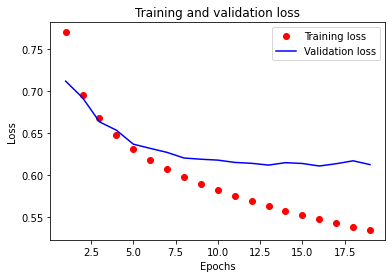

In [28]:
loss_values = model.history.history['loss']
val_loss_values = model.history.history['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [115]:
y_pred = model.predict(xTest)
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print(rmse)

0.7310768565207791


In [116]:
model = keras.models.load_model('DLmodel')

In [117]:
y_pred = model.predict(xTest)
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print(rmse)

0.7379633152278604


In [74]:
print(len(y_pred))
print(xTest[1])

1924734
[ 433  169 1444 ... 1718   73  136]


In [43]:
usersDict = {}
for index in range(0, len(df)-1): 
    userID = df.iloc[index].at['user_id']
    movieID = df.iloc[index].at['movie']
    
    if userID in usersDict.keys(): 
        usersDict[userID].append(movieID)
    else: 
        usersDict[userID] = [movieID]

In [50]:
print(list(usersDict.keys())[0])

1488844


In [44]:
with open('usersMovieDict.pkl', 'wb') as handle: 
    pickle.dump(usersDict, handle, protocol=pickle.HIGHEST_PROTOCOL)
#reload usersDict form pkl

In [118]:
def recommendMovie(model, userID, userMovieList, movieList):
    predictionDict = {}
    #predictionList = [i for i in movieList if i not in userMovieList]
    for movie in movieList:
        if movie not in userMovieList:
            #pair = tf.expand_dims([userID, movie], axis = 0)
            predictionDict[movie] = model.predict(userID, movie)
            
    sorted(predictionDict.items(), key=lambda x: x[1])
    
    return list(predictionDict.keys())[0][1]